In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from matplotlib import cm as mpl_colormaps
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

import models
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from common import utils
from common import notebook_utils as nbutils
from common.utils import CenteredNorm
from gnncsvae_experiment import GNNCSVAEExperiment
from common.ops import reparametrize

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [3]:
# these two will be used any time we load a saved checkppoint

PROJECT_ROOT = r"D:\Saarbrucken\EDA_Research\vae-disentanglement"
datapath = os.path.join(PROJECT_ROOT, "datasets")
os.environ['DISENTANGLEMENT_LIB_DATA'] = datapath

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "w_sup_reg", "w_cov_loss", 
                                         "kl_warmup_epochs",
                                         "adjacency_matrix", "loss_terms", "use_loss_weights",
                                        "controlled_capacity_increase", "iterations_c", "max_capacity", "dset_name", 
                                         "num_indept_nodes", "prior_type"
                                        ])

ExpParams = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=None,
        datapath=datapath,
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)

# Dataset = DSprites_full

In [4]:

# load the learned model here

algo_name = "LatentNN_CSVAE"
checkpoint_path = os.path.join(PROJECT_ROOT, "models", "dsprites_latentnn_w_kld4_z10_300eps.ckpt")
z_dim = 1
channels = 1
l_dim = 6
num_nodes = 5
num_indept_nodes = 5
dataset_name = "dsprites_full"
current_device = torch.device("cuda:0")
prior_type = "independent_fixed_prior"

# prep params
model_params = ModelParams(
        [z_dim], l_dim, 0, channels, 64, 64,
        1.0, 5.0, 0.0, 0, 0,
        os.path.join(PROJECT_ROOT, "adjacency_matrices", f"{dataset_name}.pkl"),
        [], False,
        False, 0, 0, dataset_name, num_indept_nodes, prior_type
)

ExpParams['channels'] = channels

# load model
print("Loading model")
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=ExpParams,
            dataset_params=None).to(current_device)


Loading model
Posterior mat:  tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
Num neighbours: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
Prior type:  independent_fixed_prior
LatentNN_CSVAE Model Initialized


In [5]:
print("Loading dataset: ", dataset_name)
dataset = nbutils.get_configured_dataset(dataset_name)
sample_loader = DataLoader(dataset, batch_size=64, shuffle = True, drop_last=True)

Loading dataset:  dsprites_full
Loaded 737280 images


# Learned Prior, Posterior activations

In [6]:
# get learned prior activations
#prior_mu_batches, gt_batches = nbutils.get_prior_mus_given_gt_labels(vae_model, sample_loader, current_device, batches=None)

# get activations generated by the images in dataset
mu_batches, gt_batches = nbutils.csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = None)

#print("Learned Prior shape:", prior_mu_batches.shape)
print("GT labels shape: ", gt_batches.shape)
print("Learend posterior shape: ", mu_batches.shape)


GT labels shape:  (663552, 6)
Learend posterior shape:  (663552, 10, 1)


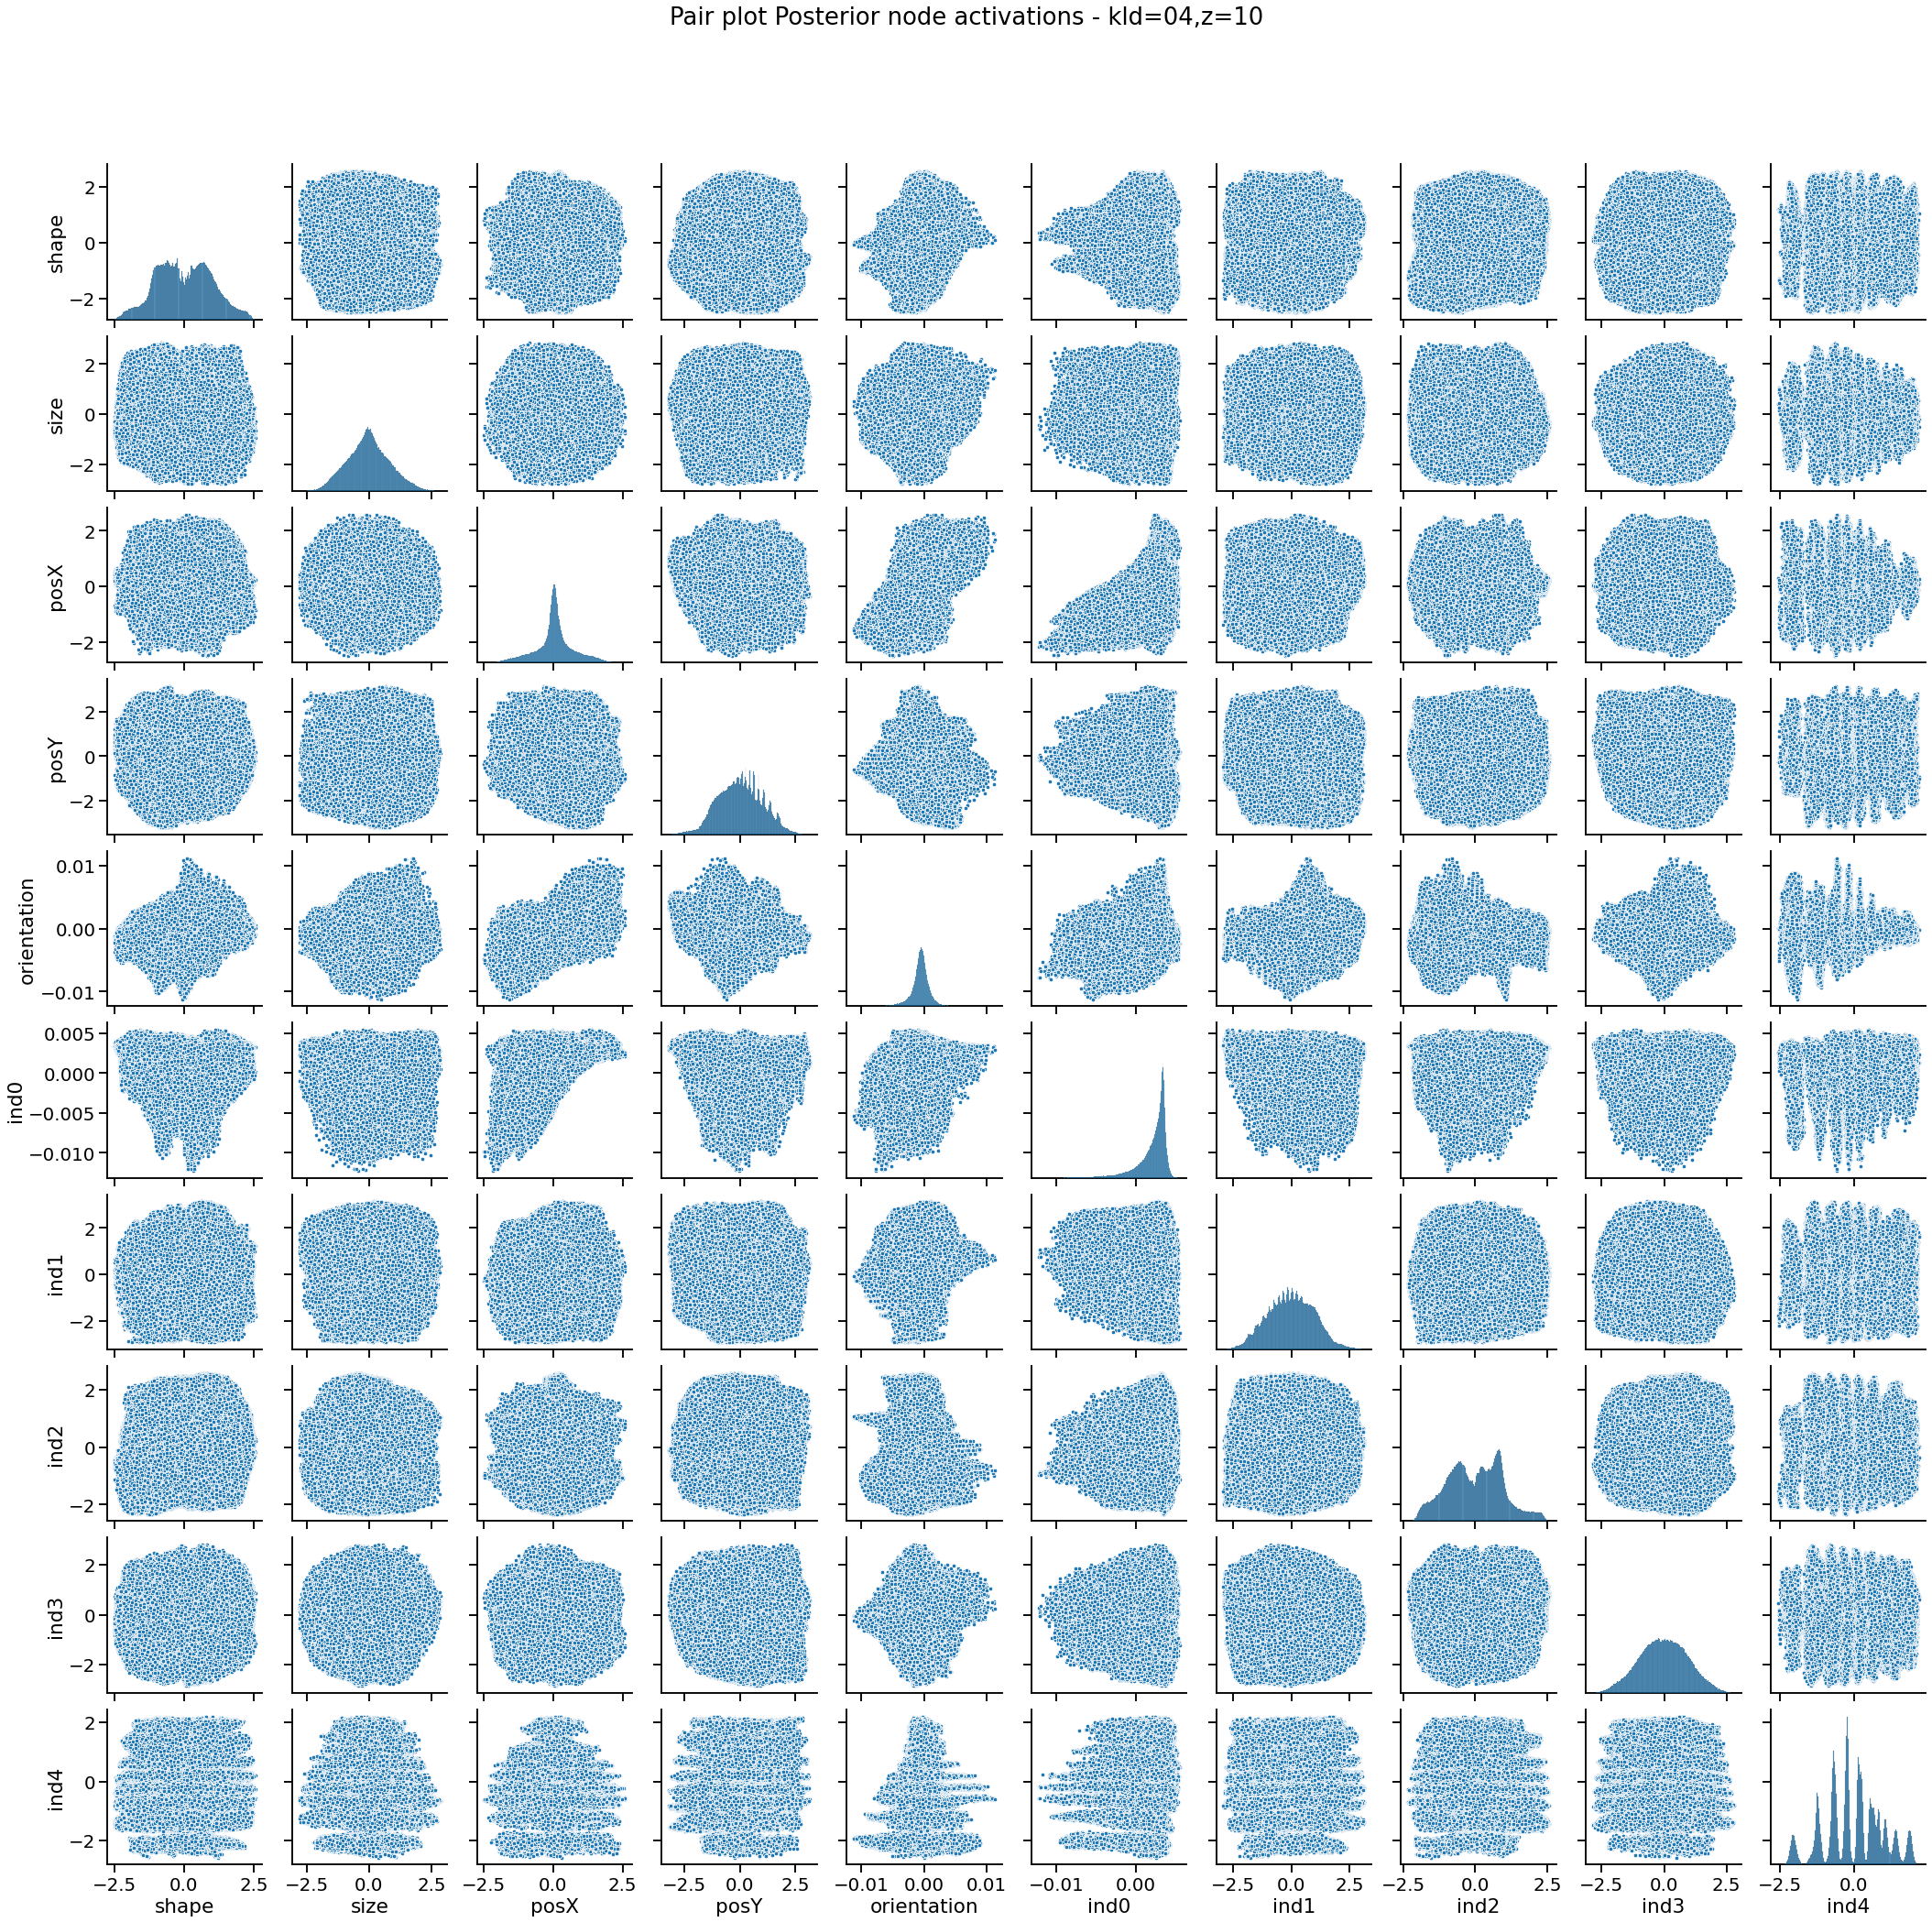

In [7]:

cols = ["shape","size","posX","posY", "orientation"]

# remove the column for 'color' which is the first col in gt
gt_batches = gt_batches[:, 1:]

# plot of relationships b/w actual Latent  gt values
# activations_df = pd.DataFrame(gt_batches, columns=cols)
# activations_df.head()
# sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
# sns_plot.fig.suptitle("Pair plot GT latent values")
# sns_plot.fig.subplots_adjust(top=0.9)

# plot learned posterior activations
# suppress the feat_dim dimension from (b,V,feat_dim) assuming it has only 1-dim
activations = mu_batches.squeeze(2)
activations_df = pd.DataFrame(activations, columns=cols + [f"ind{_}" for _ in range(num_indept_nodes)])
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Posterior node activations - kld=04,z=10")
sns_plot.fig.subplots_adjust(top=0.9)


In [8]:
# Calculate GT covariance and learned prior covariances

gt_cov = pd.DataFrame(np.cov(gt_batches.T), cols, cols)
print("Ground Truth Latent Cov")
gt_cov

Ground Truth Latent Cov


shape      size      posX      posY  orientation
shape        0.666603  0.000132 -0.000284  0.000146     0.000063
size         0.000132  0.029164  0.000104  0.000005     0.000040
posX        -0.000284  0.000104  3.459870 -0.000335    -0.000092
posY         0.000146  0.000005 -0.000335  0.088769     0.000040
orientation  0.000063  0.000040 -0.000092  0.000040     0.088694

In [10]:
post_cols = cols + [f"ind{_}" for _ in range(num_indept_nodes)]
posterior_cov = pd.DataFrame(np.cov(mu_batches.squeeze(2).T), post_cols, post_cols)
print("Learned posterior cov")
posterior_cov

Learned posterior cov


shape      size      posX      posY  orientation      ind0  \
shape        0.959150 -0.023349  0.007080  0.043180     0.000055 -0.000245   
size        -0.023349  0.717800  0.004447  0.011044     0.000124 -0.000044   
posX         0.007080  0.004447  0.482694 -0.003053     0.000498  0.000761   
posY         0.043180  0.011044 -0.003053  0.964324     0.000093 -0.000238   
orientation  0.000055  0.000124  0.000498  0.000093     0.000002  0.000001   
ind0        -0.000245 -0.000044  0.000761 -0.000238     0.000001  0.000004   
ind1         0.045856  0.011517  0.006672 -0.095484     0.000106 -0.000339   
ind2         0.003748 -0.007997 -0.002787 -0.029292     0.000014  0.000219   
ind3        -0.049407  0.012299  0.008238  0.000997    -0.000045  0.000094   
ind4         0.010214 -0.001877 -0.012172 -0.010714     0.000139  0.000354   

                 ind1      ind2      ind3      ind4  
shape        0.045856  0.003748 -0.049407  0.010214  
size         0.011517 -0.007997  0.012299 -0.001877  
posX         0.006672 -0.002787  0.008238 -0.012172  
posY        -0.095484 -0.029292  0.000997 -0.010714  
orientation  0.000106  0.000014 -0.000045  0.000139  
ind0        -0.000339  0.000219  0.000094  0.000354  
ind1         0.979128 -0.019132 -0.007194  0.006896  
ind2        -0.019132  0.918912  0.005223  0.000880  
ind3        -0.007194  0.005223  0.919842 -0.011044  
ind4         0.006896  0.000880 -0.011044  0.956811

In [11]:
images, labels = next(sample_loader.__iter__())

In [12]:
vae_model.num_nodes

10

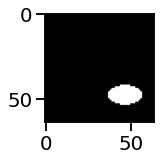

In [14]:
ref_img = images[15]
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(ref_img.permute(1,2,0), cmap='gray')
ref_img = ref_img.unsqueeze(0).to(current_device)

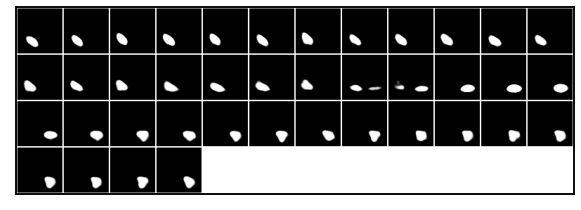

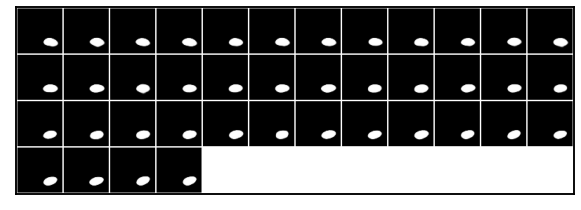

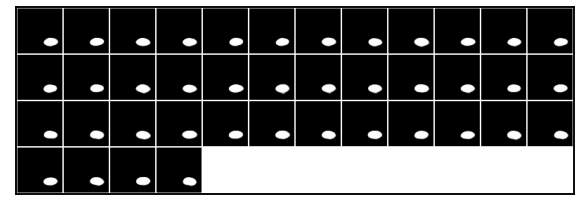

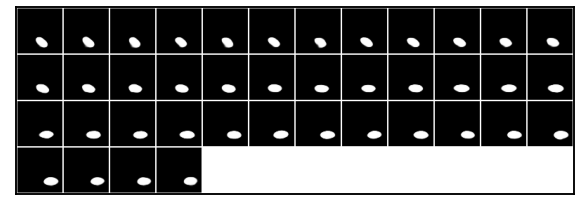

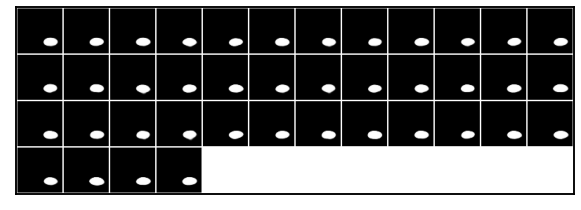

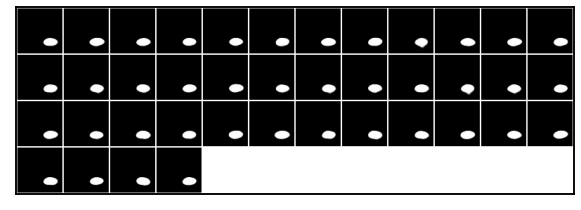

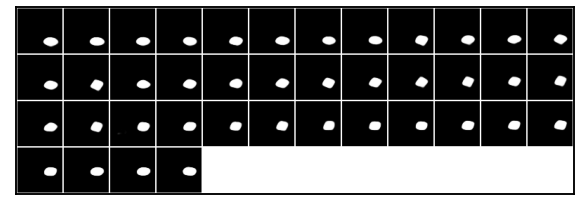

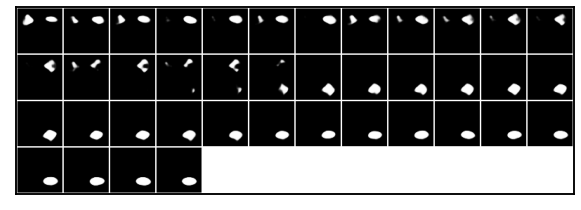

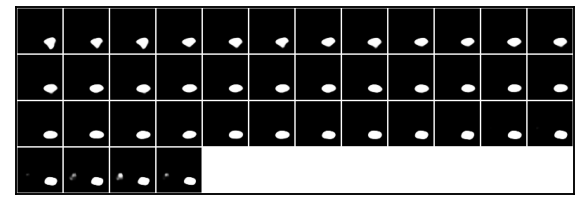

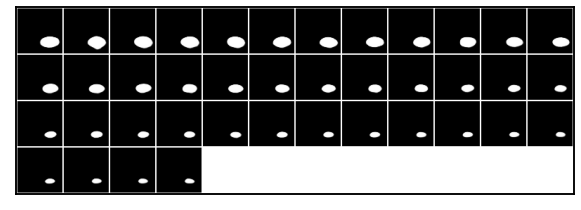

In [15]:
# hard interventions
intervention_values = torch.arange(-2.,2.,0.1).to(current_device)
anchor_image = ref_img

for intervened_node in range(0, vae_model.num_nodes):
    # if I do it like this, then I'm keeping the same anchor_image (so same mu) but
    # I sample a new z every time which can cause unnecessary variance in the results
    # I should try with keeping the z same through out
    nbutils.latentnn_show_intervention_atlas_from_anchor(intervened_node, intervention_values, anchor_image, vae_model)


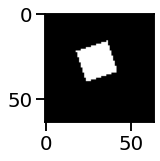

In [16]:
ref_img = images[1]
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(ref_img.permute(1,2,0), cmap='gray')
ref_img = ref_img.unsqueeze(0).to(current_device)


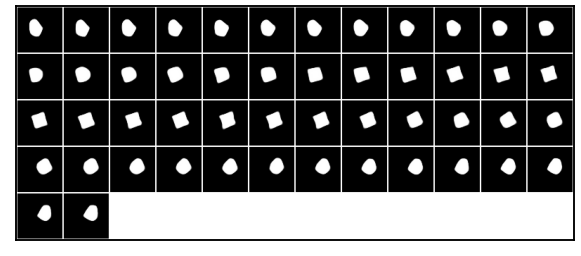

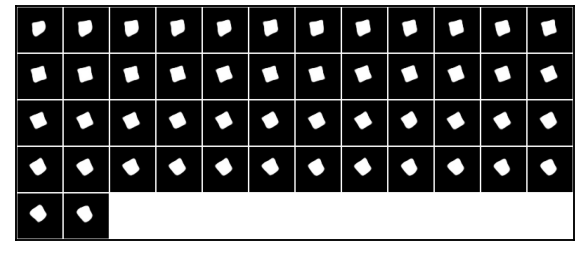

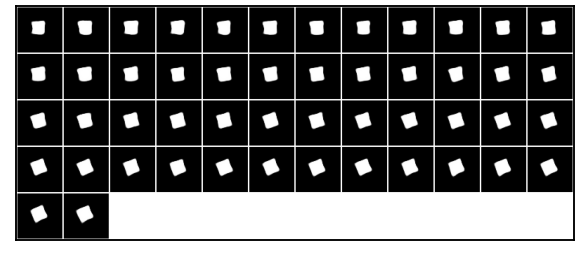

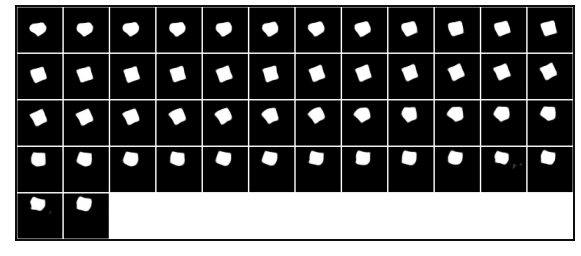

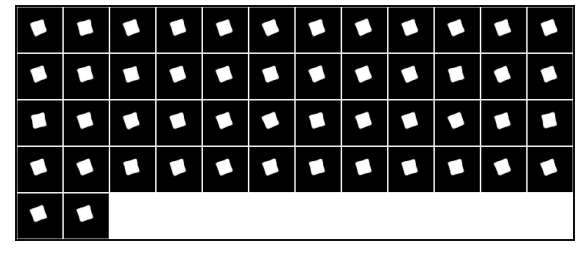

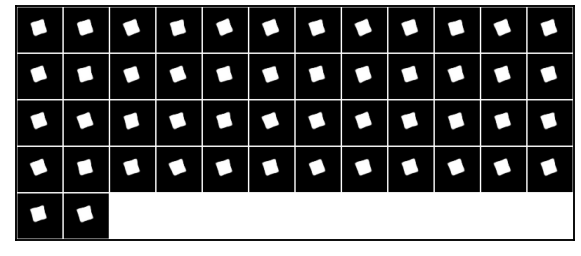

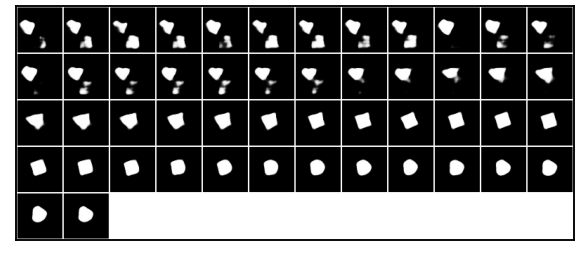

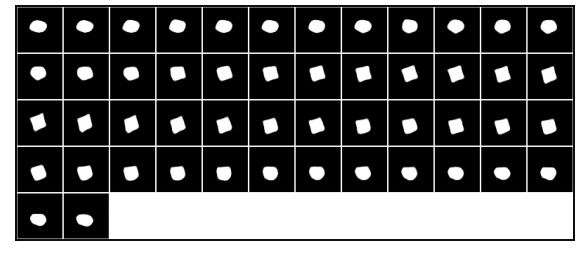

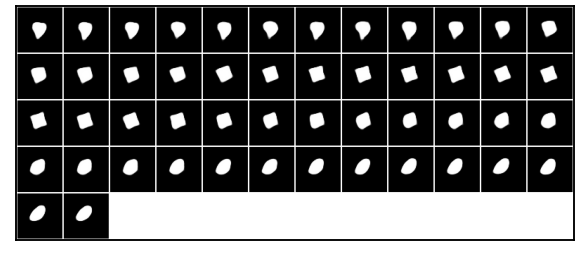

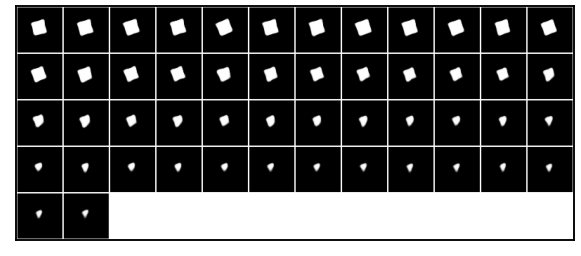

In [17]:
# hard interventions
intervention_values = torch.arange(-2.5,2.5,0.1).to(current_device)
anchor_image = ref_img

for intervened_node in range(0, vae_model.num_nodes):
    nbutils.latentnn_show_intervention_atlas_from_anchor(intervened_node, intervention_values, anchor_image, vae_model)


Observations

- node 1 : posX
- node 2 : posY
- node 3 : not sure
- node 4 : scale
- node 5 : rotation

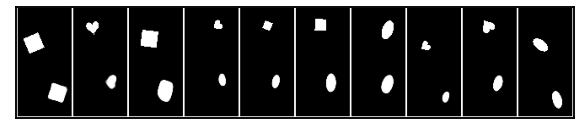

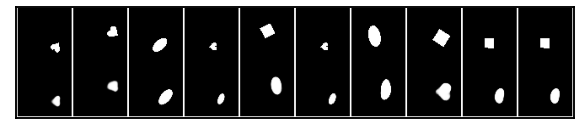

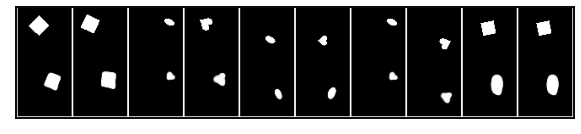

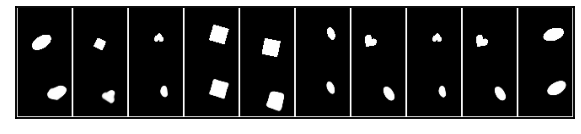

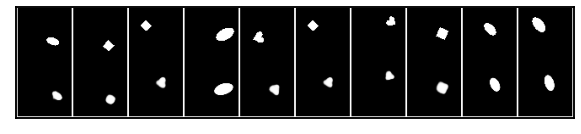

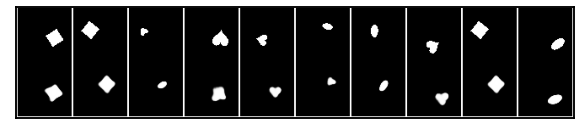

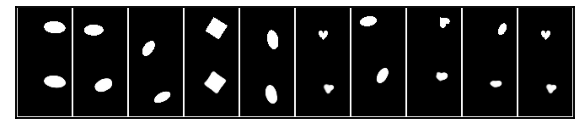

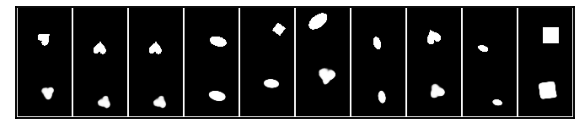

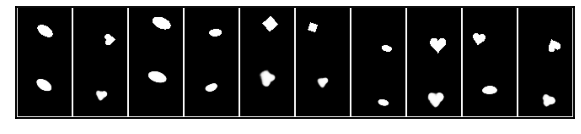

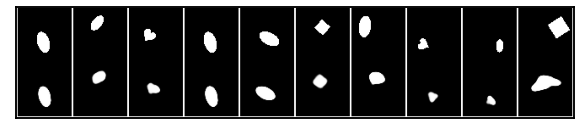

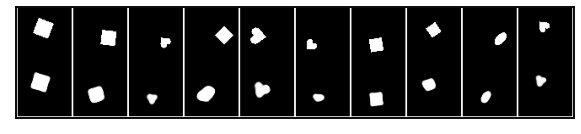

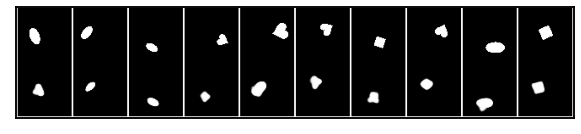

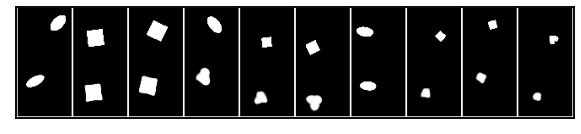

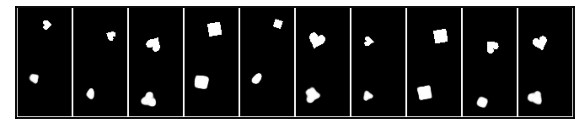

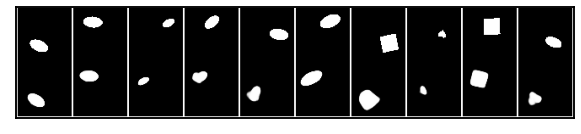

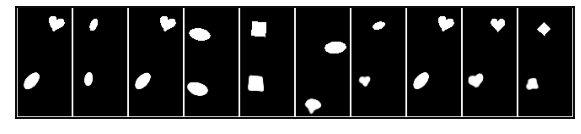

In [19]:
intervened_node = 0
num_samples = 10
# as we go down the plots, value ranges from -2 to +2
intervention_values = np.arange(-2., 2., 0.25)   

nbutils.latentnn_show_intervention_comparison(intervened_node, intervention_values, num_samples, 
                                      sample_loader, vae_model, current_device)

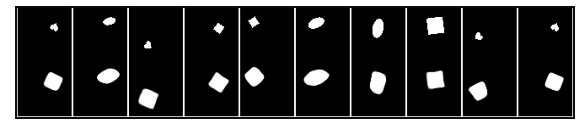

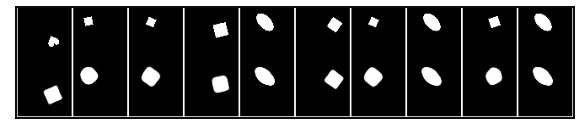

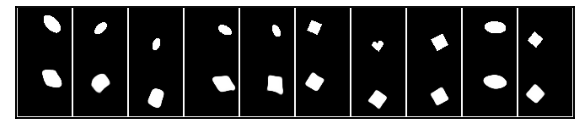

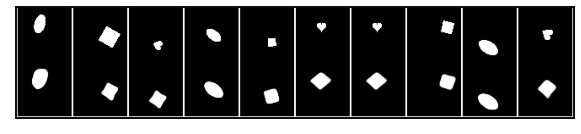

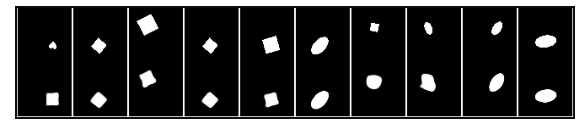

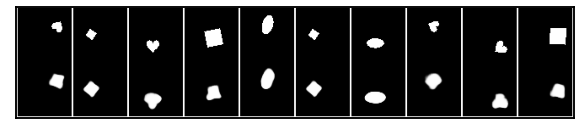

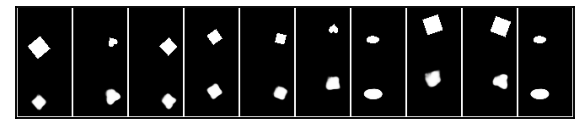

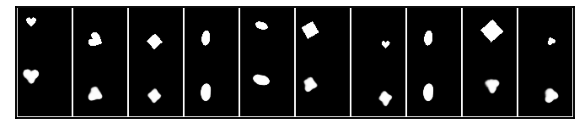

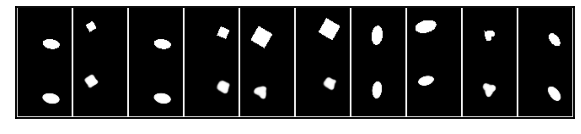

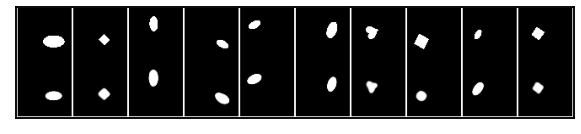

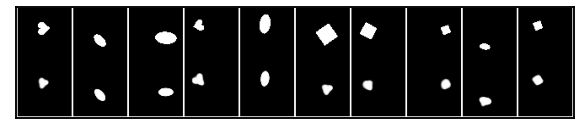

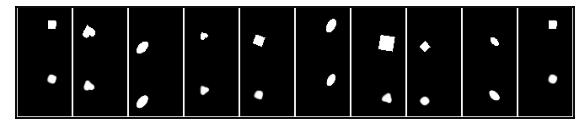

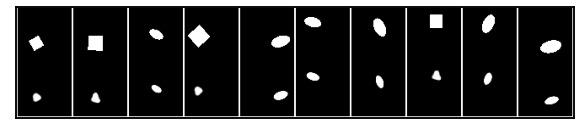

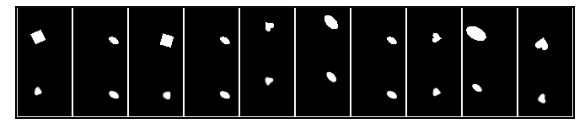

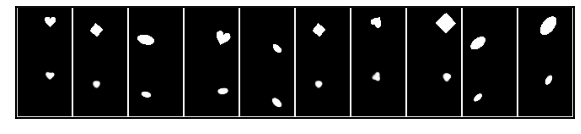

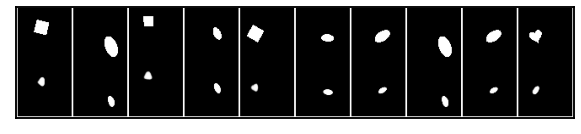

In [20]:
intervened_node = 4
num_samples = 10
# as we go down the plots, value ranges from -2 to +2
intervention_values = np.arange(-2., 2., 0.25)   

nbutils.latentnn_show_intervention_comparison(intervened_node, intervention_values, num_samples, 
                                      sample_loader, vae_model, current_device)

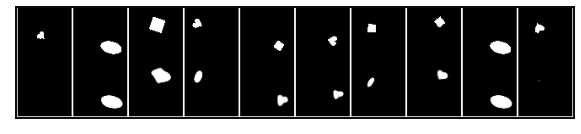

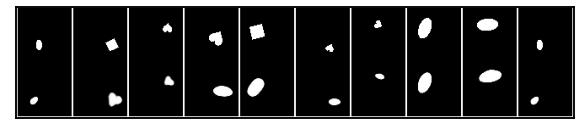

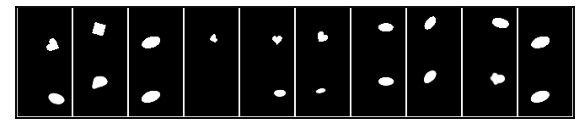

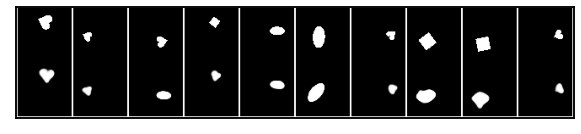

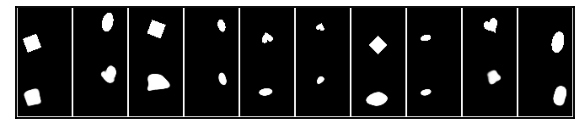

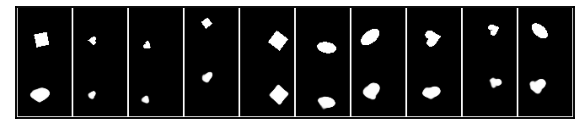

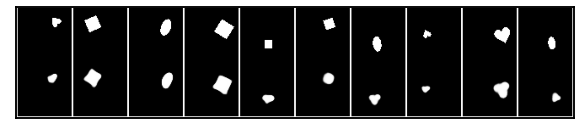

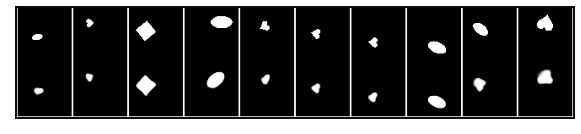

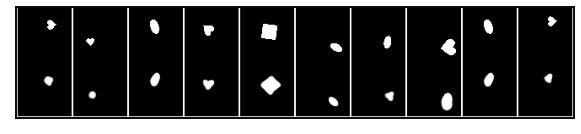

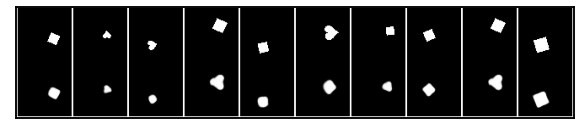

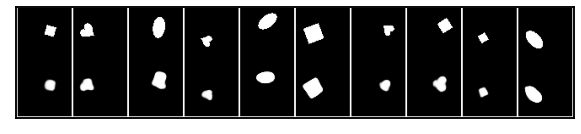

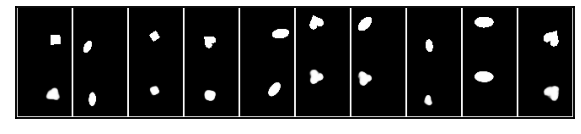

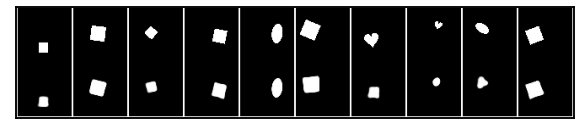

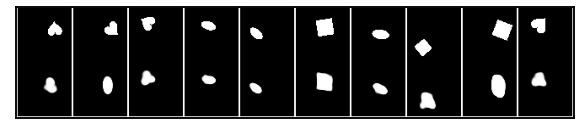

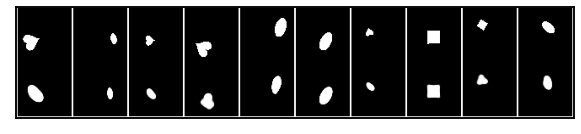

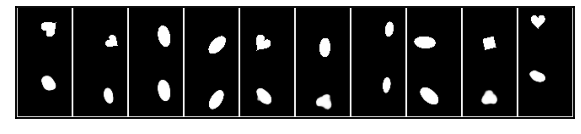

In [21]:
intervened_node = 3
num_samples = 10
# as we go down the plots, value ranges from -2 to +2
intervention_values = np.arange(-2., 2., 0.25)   

nbutils.latentnn_show_intervention_comparison(intervened_node, intervention_values, num_samples, 
                                      sample_loader, vae_model, current_device)